In [2]:
import pandas as pd 
import numpy as np
import keras
import math 
import random 

from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

2023-04-27 14:29:53.297349: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 14:29:53.436860: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-27 14:29:53.436886: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-27 14:29:54.153689: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [9]:
df = pd.read_csv("data/TSLA-d.csv", index_col=0)
df.pop("Volume")
df["Range"] = (df["High"] - df["Low"]) / df["Open"]
df.pop("Open")
df.pop("High")
df.pop("Low")
df['Change'] = df["Adj Close"].pct_change()
df = df. tail(-1) 
df.pop("Close")

df.head()

,Adj Close,Range,Change
Date,,,
2010-06-30,1.588667,0.276076,-0.002512
2010-07-01,1.464000,0.226000,-0.078473
2010-07-02,1.280000,0.190870,-0.125683
2010-07-06,1.074000,0.208500,-0.160937
2010-07-07,1.053333,0.100610,-0.019243


In [10]:
# III.A: Outliers in Change Column

In [11]:
'''
The model is best able to extract generalizations from the data if most of the data falls within a normal 
range. Outliers tend to skew the data such that some values (which may be important) will be almost ignored, 
whereas others will be overemphasized. 

Just to clarify I'm not talking here about outliers that may reflect mistakes in the data collection process 
necessarily (bad data samples can often just be discarded), but simply events of unusual magnitude. For 
example, price data that contains a swan event such as a major flash 
crash that is many times larger than the normal daily move may de-emphasize the magnitude of all of the others 
days' data. This can cause a model trained on data that contains the swan event to come up with very different results 
compared to the same model trained on data that did not contain the event. That's not ideal, because it 
indicates that something is interfering with the model's ability to generalize from the available data.
'''


"\nThe model is best able to extract generalizations from the data if most of the data falls within a normal \nrange. Outliers tend to skew the data such that some values (which may be important) will be almost ignored, \nwhereas others will be overemphasized. \n\nJust to clarify I'm not talking here about outliers that may reflect mistakes in the data collection process \nnecessarily (bad data samples can often just be discarded), but simply events of unusual magnitude. For \nexample, price data that contains a swan event such as a major flash \ncrash that is many times larger than the normal daily move may de-emphasize the magnitude of all of the others \ndays' data. This can cause a model trained on data that contains the swan event to come up with very different results \ncompared to the same model trained on data that did not contain the event. That's not ideal, because it \nindicates that something is interfering with the model's ability to generalize from the available data.\n"

In [12]:
# III.A: Outliers in Change Column

<AxesSubplot:xlabel='Date'>

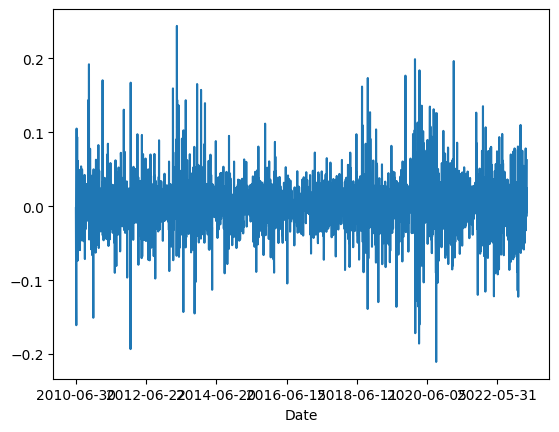

In [13]:
'''
III.A.1: Plot Change Before Handling Outliers

Take another peek at the Change column before handling outliers. Note that just by visual inspection, it's 
clear that most of the data falls into a very small percentage of the full range of values. That should be 
corrected so that at least more than 50% of the data falls within more than 50% of the range (just ballpark 
figures here, there is no real rule of thumb. It would depend on the goals of the data, and your idea of 
what the ideal 'balance' of data is for your situation; but we can see that the data here is clearly not 
well balanced). 
'''
df['Change'].plot()

In [14]:
'''
III.A.2: Function to Squash Outliers

I don't want to remove the rows that contain outliers, because that would be removing real data that we want 
to give to the model. I don't 
want to zero the values either as that would skew the data in a different direction. Instead I would like to 
'squash' the values to within a reasonable range, where outliers >=n will be treated the same as values 
that are equal to n.
'''
def squash_col_outliers(
    df: pd.DataFrame, 
    col_name: str, 
    min_quantile: float =0.01, 
    max_quantile:float =0.99
): 
    q_lo = df[col_name].quantile(min_quantile)
    q_hi  = df[col_name].quantile(max_quantile)
    
    df.loc[df[col_name] >= q_hi, col_name] = q_hi
    df.loc[df[col_name] <= q_lo, col_name] = q_lo
    return df

'''
Min and Max before squashing:
'''
print('MIN:', df['Change'].min())
print('MAX:', df['Change'].max())

MIN: -0.2106282385165198
MAX: 0.24395072987549127


In [15]:
'''
III.A.3: Squash Outliers in Change
'''
df = squash_col_outliers(df, 'Change')

'''
Min and Max after squashing:
'''
print(df['Change'].max())
print(df['Change'].min())

0.10999024964609014
-0.09005126578365338


<AxesSubplot:xlabel='Date'>

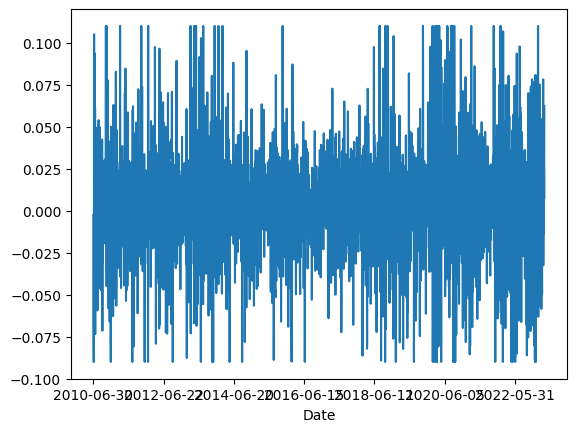

In [16]:
'''
III.A.4: Plot Change After Handling Outliers

Now we can visually see in the plot of Change that there's a more balanced distribution of values, that will be 
more healthy for the model to digest. Again, there is no formula for the perfect balance, and this is part 
of a discovery process in which we'd like to get enough information to intuit a good enough rule, or what is 
closer to an ideal. 
'''
df['Change'].plot()

In [ ]:
# III.B Outliers in Range Column

<AxesSubplot:xlabel='Date'>

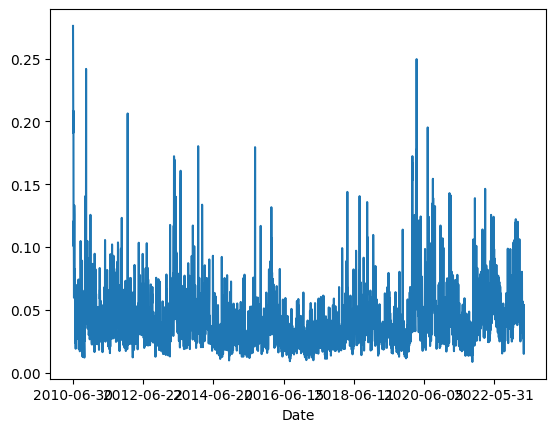

In [17]:
'''
III.B.1: Plot Range Before Handling Outliers

The shape of the Range data is a bit different, so I'm going to do basically the same thing, but I'm going 
to pass different values for the upper and lower limits, so that the left of the distribution will be less 
affected by squashing, and the right of the distribution will be more affected (which is where it's needed). 
I can do that by just passing lower values (lower than the default) for both min_quantile and max_quantile. 
That will cause the function to squash more on the top and less (or not at all, in this case) on the bottom. 
'''
df['Range'].plot()

<AxesSubplot:xlabel='Date'>

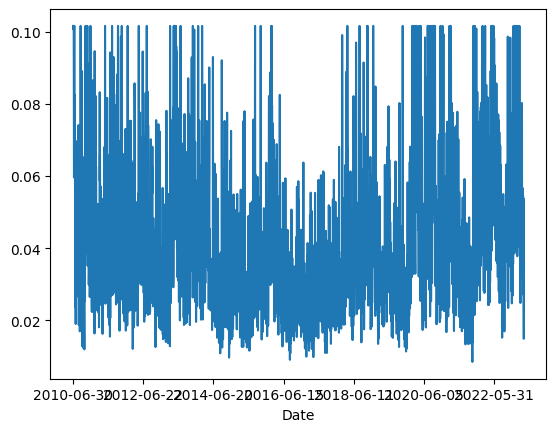

In [18]:
'''
III.B.2: Squash Outliers in Range
'''
df = squash_col_outliers(df, 'Range', min_quantile=0.0, max_quantile=0.97)

'''
And now, we likewise see a more favorable distribution of values. 
'''
df['Range'].plot()